In [1]:
# TODO - plot function ASTs

# TODO: FIRST THING TOMORROW - need to draw the GNN diagram, use this as a BLUEPRINT
# for the model design

# - I expect it to evolve as I go, but need to START SOMEWHERE
# - Annotate what the feature vectors look like for nodes
# - How many hops away do we need to gather information (GNN depth)?
# - What virtual edges might we insert? (e.g. connect all instances of target variable)
# - Should we MASK OUT the target variable?

# also...
# - look at function proto recovery accuracy

In [2]:
import os
import pandas as pd
from pathlib import Path

# Execute this notebook headlessly using something like:
#
# EXP_FOLDER=~/test_builds/coreutils.exp/ jupyter nbconvert --to html --execute characterize_dataset.ipynb --no-input
#

MANUAL_EXP_FOLDER = Path.home()/'test_builds'/'astera3.exp'

# take the env-var-specified experiment if present
EXP_FOLDER = Path(os.environ['EXP_FOLDER']) if 'EXP_FOLDER' in os.environ else MANUAL_EXP_FOLDER

In [3]:
# import wildebeest as wdb
# wdb.get_experiment_names()
ast_json = EXP_FOLDER/'rundata'/'run1'/'0.fighter'/'ast_dumps'/'stripped'/'Func143603-FUN_00143603.json'
[x for x in (EXP_FOLDER/'rundata'/'run1'/'0.fighter'/'ast_dumps'/'stripped').iterdir() if '143603' in x.name]


[PosixPath('/home/cls0027/test_builds/astera3.exp/rundata/run1/0.fighter/ast_dumps/stripped/Func143603-FUN_00143603.json')]

# Prepare data for PyG Model
*Sticking this here for now for sake of time...*

We need to **quickly** write the code to take our data tables and convert each variable into the format ready to go for PyG

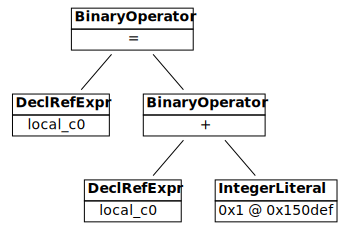

In [34]:
import astlib
from astlib.color_ast import highlight_var_refs, highlight_khop_neighborhood
from astlib.find_all_references import *

run_folder = EXP_FOLDER/'rundata'/'run1'

# list((EXP_FOLDER/'rundata'/'run1').iterdir())
# list(run_folder.glob('*.csv'))

# def generate_dtpredict_dataset(run_folder:Path):
locals_df = pd.read_csv(run_folder/'locals.csv')

# NOTE: need to go back to AST JSON directly to read it back in (we have to use the whole thing anyway)
# NOTE: we could be a bit more efficient by passing the ASTs we already have in-memory to this function
# instead of reading them back again from the file...
# TODO: would be nice to just have the AST filenames here in the functions table though
funcs_df = pd.read_csv(run_folder/'functions.csv')


addr = locals_df.FunctionStart.unique()[0]
ast_file = funcs_df[funcs_df.FunctionStart==addr].AstJson_Strip.iloc[0]

ast, slib = astlib.json_to_ast(ast_file)

# locals_df[locals_df.FunctionStart]
for i, x in enumerate(locals_df.groupby(['BinaryId', 'FunctionStart'])):
    # print(x)
    if i > 5:
        break

x[1]

# AHA! DataFrameGroupBy object behaves like an iterable of tuples:
    # [0]: tuple of values for the columns you grouped by
    # [1]: corresponding data frame with this subset of the data

##########################################################
# TODO: write a function that converts the local variables into pyg format for a given function dataframe
# - then I can pass this function to a groupby() that splits the data by unique binary/function combos
#   and it will work as intended
##########################################################
df_list = locals_df.groupby(['BinaryId', 'FunctionStart']).pipe(lambda gb: [x[1] for x in gb])
# --------------------
# TODO: for all locals in this function (start here, we'll see how it evolves)
# 1. Find all references to the local (see below)
# 2. Extract those statements in which the reference "participates" (see below)
# 3. Join the target nodes all into one, preserving existing connections
#       - ok to do this "directly" on the data, we read it from the file and won't modify original file
# 4. Write this resulting graph to a file ready to go for pyg
#       - how does pyg want this? just a json file? look at pyg tutorials
#
#       >>> only need to save the data/features we need for the model (and just enough metadata
#           to refer back to the func/var of interest)
##########################################################

# TODO: convert this to a function we call using pipe() above
df = df_list[33]

addr = df.FunctionStart.iloc[0]
ast_file = funcs_df[funcs_df.FunctionStart==addr].iloc[0].AstJson_Strip

ast, slib = astlib.json_to_ast(ast_file)
df.drop(columns=['LocType_Debug','LocRegName_Debug','LocOffset_Debug','LocType_Strip','LocRegName_Strip','LocOffset_Strip'])

# TODO: for each local... i in range(len(df))
name_strip = df.iloc[0].Name_Strip

fbody = ast.inner[-1].inner[-1]

decl_ref_nodes = FindAllVarRefs(name_strip).visit(fbody)
# node = decl_ref_nodes[0]
# for node in decl_ref_nodes:
#     display(node.parent.parent.parent.render(format_node=highlight_khop_neighborhood(node, 2, 'red')))

statements = FindAllStatementsContainingVar(name_strip).collect_statement_set(fbody)
statements

# for s in statements:
    # display(s.statement_node.render(format_node=highlight_khop_neighborhood(s.refexprs, 2)))

# hex(addr)
# name_strip
# df.iloc[0]

# zero out parent connection to ensure we don't reach outside
# the statement
# ----------------------------------------------------------------
# NOTE: it might not be a bad idea to just go N hops out and not worry
# about if we're stopping at statement boundaries or not...
# (...or it might confuse the learning process in some cases when adjacent
# statements have nothing to do with our statement)
# ----------------------------------------------------------------
for s in statements:
    s.statement_node.parent = None

# for s in statements:
#     display(s.statement_node.render(format_node=highlight_khop_neighborhood(s.refexprs, 2)))

# TODO: build up a new graph SPECIFICALLY FOR PYG
# - save only the feature information and minimal metadata we REALLY NEED
# - build this as a new graph structure (either generic edges or allowing K parents)
# - render it if desired...

# ----------------------------------------------------------------
# TODO: go back to pyg tutorials and see what format pyg wants...then make this fit!
# ----------------------------------------------------------------

s = statements[2]
s.statement_node.render()
old_parent = s.refexprs[0].parent
s.refexprs[0].parent = [old_parent, s.refexprs[1].parent]
s.refexprs[0].parent[0].render()

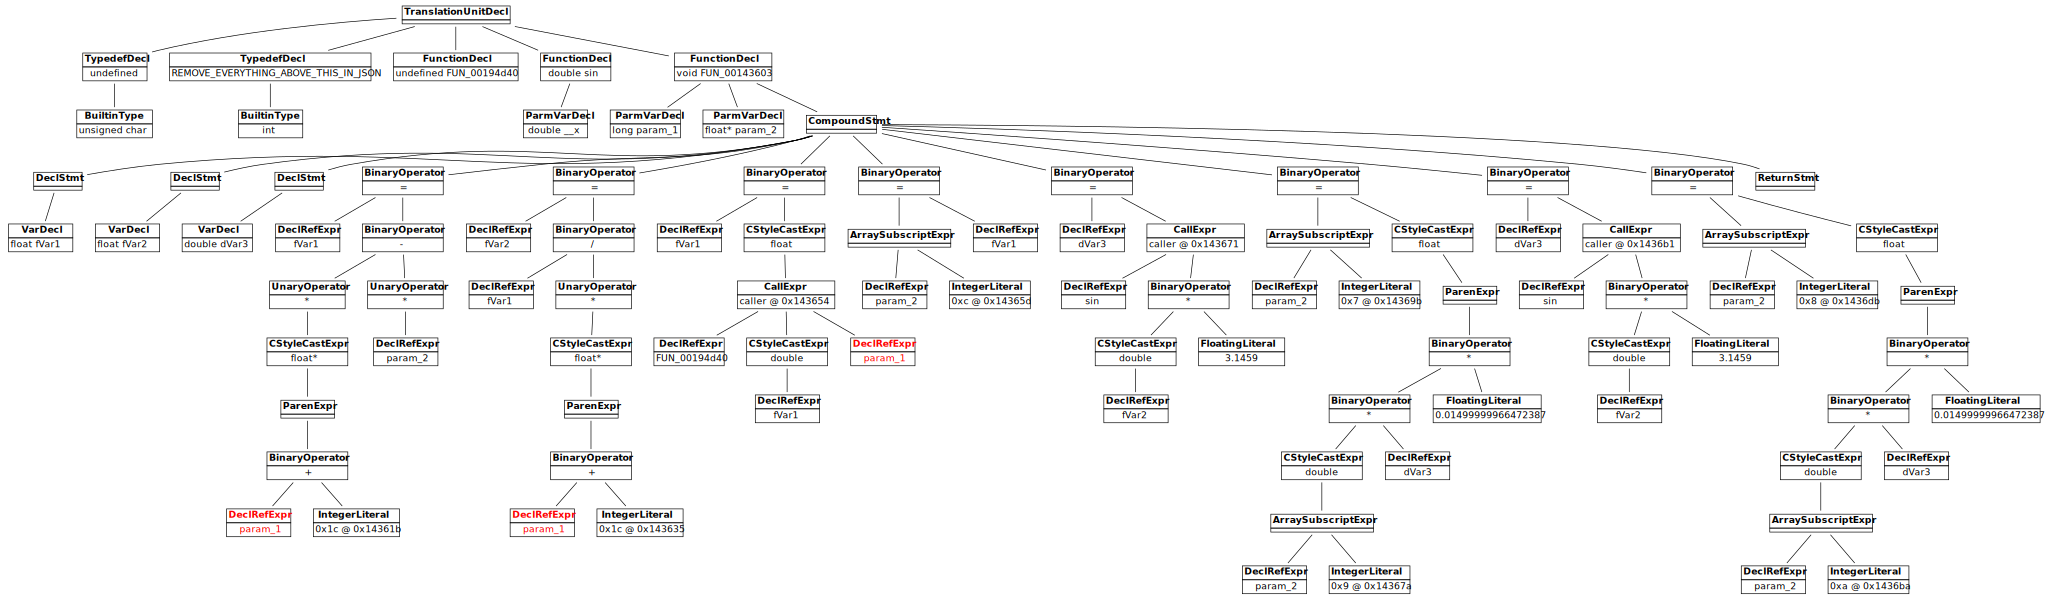

In [5]:
import astlib
from astlib.color_ast import highlight_var_refs

ast, slib = astlib.json_to_ast(ast_json)
ast.inner[-1].inner[-1].inner[8].inner[0].inner

# if node.kind == highlight_kind:
#             attrs.font_color = highlight_color
# def highlight_var(varname:str):
#     def do_highlight(node, attrs):
#         if node.kind == 'DeclRefExpr' and node.referencedDecl.name == varname:
#             attrs.font_color = 'red'
#     return do_highlight

ast.render(format_node=highlight_var_refs('param_1'))

In [6]:
pvdecl = ast.inner[-1].inner[0]
pvdecl.name

fbody = ast.inner[-1].inner[-1]
from astlib.find_all_references import *

res = FindAllVarRefs('param_1').visit(fbody)
# res[0].parent.parent.parent.parent.parent.parent
statements = FindAllStatementsContainingVar('param_1').collect_statement_set(fbody)
statements

In [7]:
for s in statements:
    display(s.render(format_node=highlight_var_refs('param_1')))

AttributeError: 'Statement' object has no attribute 'render'